In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Base class for generic regressor
# (this is already complete!)
class BaseRegressor():

    def __init__(self, num_feats, learning_rate=0.01, tol=0.001, max_iter=100, batch_size=10):

        # Weights are randomly initialized
        self.W = np.random.randn(num_feats + 1).flatten()

        # Store hyperparameters
        self.lr = learning_rate
        self.tol = tol
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.num_feats = num_feats

        # Define empty lists to store losses over training
        self.loss_hist_train = []
        self.loss_hist_val = []
    
    def train_model(self, X_train, y_train, X_val, y_val):

        # Padding data with vector of ones for bias term
        X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
        X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    
        # Defining intitial values for while loop
        prev_update_size = 1
        iteration = 1

        # Repeat until convergence or maximum iterations reached
        while prev_update_size > self.tol and iteration < self.max_iter:

            # Shuffling the training data for each epoch of training
            shuffle_arr = np.concatenate([X_train, np.expand_dims(y_train, 1)], axis=1)
            np.random.shuffle(shuffle_arr)
            X_train = shuffle_arr[:, :-1]
            y_train = shuffle_arr[:, -1].flatten()

            # Create batches
            num_batches = int(X_train.shape[0] / self.batch_size) + 1
            X_batch = np.array_split(X_train, num_batches)
            y_batch = np.array_split(y_train, num_batches)

            # Create list to save the parameter update sizes for each batch
            update_sizes = []

            # Iterate through batches (one of these loops is one epoch of training)
            for X_train, y_train in zip(X_batch, y_batch):

                # Make prediction and calculate loss
                y_pred = self.make_prediction(X_train)
                train_loss = self.loss_function(y_train, y_pred)
                self.loss_hist_train.append(train_loss)

                # Update weights
                prev_W = self.W
                grad = self.calculate_gradient(y_train, X_train)
                new_W = prev_W - self.lr * grad 
                self.W = new_W

                # Save parameter update size
                update_sizes.append(np.abs(new_W - prev_W))

                # Compute validation loss
                val_loss = self.loss_function(y_val, self.make_prediction(X_val))
                self.loss_hist_val.append(val_loss)

            # Define step size as the average parameter update over the past epoch
            prev_update_size = np.mean(np.array(update_sizes))

            # Update iteration
            iteration += 1
    
    def plot_loss_history(self):

        # Make sure training has been run
        assert len(self.loss_hist_train) > 0, "Need to run training before plotting loss history."

        # Create plot
        fig, axs = plt.subplots(2, figsize=(8, 8))
        fig.suptitle('Loss History')
        axs[0].plot(np.arange(len(self.loss_hist_train)), self.loss_hist_train)
        axs[0].set_title('Training')
        axs[1].plot(np.arange(len(self.loss_hist_val)), self.loss_hist_val)
        axs[1].set_title('Validation')
        plt.xlabel('Steps')
        fig.tight_layout()
        plt.show()

    def reset_model(self):
        self.W = np.random.randn(self.num_feats + 1).flatten()
        self.loss_hist_train = []
        self.loss_hist_val = []
        
# Implement logistic regression as a subclass
class LogisticRegressor(BaseRegressor):

    def __init__(self, num_feats, learning_rate=0.01, tol=0.001, max_iter=100, batch_size=10):
        super().__init__(
            num_feats,
            learning_rate=learning_rate,
            tol=tol,
            max_iter=max_iter,
            batch_size=batch_size
        )
        # Add 1 to the number of features for the bias term
        self.W = np.random.randn(num_feats + 1)
    
    def make_prediction(self, X) -> np.array:
        """
        Implement logistic function to get estimates (y_pred) for input X values. The logistic
        function is a transformation of the linear model into an "S-shaped" curve that can be used
        for binary classification.

        Arguments: 
            X (np.ndarray): Matrix of feature values.

        Returns: 
            The predicted labels (y_pred) for given X.
        """

        # Add bias column of ones to X
        #X = np.hstack([X, np.ones((X.shape[0], 1))])

        linear = np.dot(X, self.W)
        y_pred = 1 / (1 + np.exp(-linear))
        return y_pred


    def loss_function(self, y_true, y_pred) -> float:
        """
        TODO: Implement binary cross entropy loss, which assumes that the true labels are either
        0 or 1. (This can be extended to more than two classes, but here we have just two.)

        Arguments:
            y_true (np.array): True labels.
            y_pred (np.array): Predicted labels.

        Returns: 
            The mean loss (a single number).
        """
        # epsilon = 1e-5 # avoid division by zero
        # loss = - np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))
        # return loss
        epsilon = 1e-5 # avoid division by zero
        loss = - np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))
        regularization = 0.01 * np.sum(self.W**2)  # L2 regularization term
        loss += regularization
        return loss
    

    def calculate_gradient(self, y_true, X) -> np.ndarray:
        """
        Calculates the gradient of the binary cross-entropy loss function with respect to the weights.

        Arguments:
            y_true (np.array): True labels.
            X (np.ndarray): Matrix of feature values.

        Returns:
            Vector of gradients.
        """

        y_pred = self.make_prediction(X)
        error = y_true - y_pred
        gradient = -np.mean(np.multiply(X.T, error).T, axis=0)
        return gradient
    
    def plot_data(self, X, y):
        """
        Plots the input data with the binary labels.
        """
        fig, ax = plt.subplots()
        ax.scatter(X[:, 0], X[:, 1], c=y)
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.set_title("Input Data")
        plt.show()

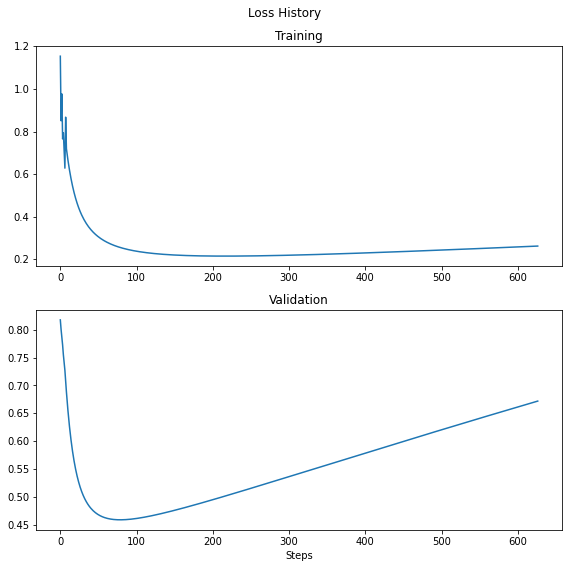

In [33]:
# Generate synthetic data for binary classification
np.random.seed(42)
X = np.random.normal(size=(100, 2))
y = np.random.binomial(1, 1 / (1 + np.exp(-(2*X[:,0] + 3*X[:,1] - 1))), size=(100,))

# Split data into training and validation sets
train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:], y[train_size:]

# Create logistic regression model
logreg = LogisticRegressor(num_feats=2, learning_rate=0.1, tol=0.001, max_iter=1000, batch_size=10)

# Train model on training data
logreg.train_model(X_train, y_train, X_val, y_val)

# Plot loss history
logreg.plot_loss_history()


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split

def loadDataset(
    features = [
        'Penicillin V Potassium 500 MG',
        'Computed tomography of chest and abdomen',
        'Plain chest X-ray (procedure)', 
        'Low Density Lipoprotein Cholesterol',
        'Creatinine',
        'AGE_DIAGNOSIS'
    ],
    split_percent=None,
    split_seed=42
):
    """

    YOU DO NOT NEED TO MODIFY THIS FUNCTION.
    Load NSCLC dataset as NumPy arrays.

    Arguments:
        features (list): Features to pull from the data. (The full list of potential features is below.)
        split_percent (float, None): Percentage of data to use for training. (Optional.)
        split_seed (int): Seed to use for randomly splitting the data. (Optional.)
    
    Output:
        X (np.ndarray) and y (np.array), corresponding to dataset and labels, respectively.
        If split_percent is specified, returns X_train, X_test, y_train, y_test.

    --------

    List of potential features. NSCLC is the classification label, where 1 = NSCLC and 0 = small cell lung cancer.

    'NSCLC', 'GENDER', 'Penicillin V Potassium 250 MG', 'Penicillin V Potassium 500 MG',
    'Computed tomography of chest and abdomen', 'Plain chest X-ray (procedure)', 'Diastolic Blood Pressure',
    'Body Mass Index', 'Body Weight', 'Body Height', 'Systolic Blood Pressure',
    'Low Density Lipoprotein Cholesterol', 'High Density Lipoprotein Cholesterol', 'Triglycerides',
    'Total Cholesterol', 'Documentation of current medications',
    'Fluticasone propionate 0.25 MG/ACTUAT / salmeterol 0.05 MG/ACTUAT [Advair]',
    '24 HR Metformin hydrochloride 500 MG Extended Release Oral Tablet',
    'Carbon Dioxide', 'Hemoglobin A1c/Hemoglobin.total in Blood', 'Glucose', 'Potassium', 'Sodium', 'Calcium',
    'Urea Nitrogen', 'Creatinine', 'Chloride', 'AGE_DIAGNOSIS'

    """

    # Read dataset
    full_df = pd.read_csv("../data/nsclc.csv", index_col="ID")
    
    # Always include the class label
    if "NSCLC" not in features: 
        features.append("NSCLC")
    
    # Select desired features
    full_df = full_df.loc[:,features]
    
    # Split and return appropriate datasets
    X = full_df.loc[:, full_df.columns != 'NSCLC'].values
    y = full_df["NSCLC"].values
    
    if split_percent is not None: 
        return train_test_split(X, y, train_size=split_percent, random_state=split_seed)

    return X,y

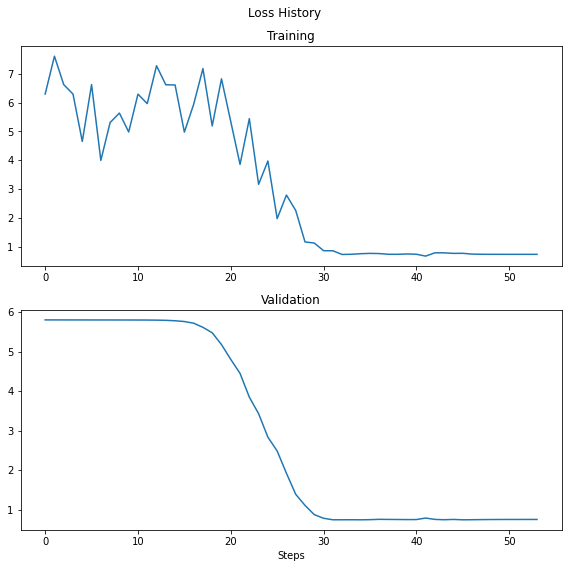

Test accuracy: 50.00%


In [35]:
# Load dataset
X_train, X_test, y_train, y_test = loadDataset(features=['AGE_DIAGNOSIS', 'Creatinine', 'Low Density Lipoprotein Cholesterol', 'NSCLC'], split_percent=0.8)

# Initialize model
model = LogisticRegressor(num_feats=X_train.shape[1], learning_rate=0.001, tol=0.00001, max_iter=1000, batch_size=35)

# Train model
model.train_model(X_train, y_train, X_test, y_test)

# Plot loss history
model.plot_loss_history()

# Predict labels for test set
X_test_with_bias = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
y_pred = np.round(model.make_prediction(X_test_with_bias))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Test accuracy: {:.2f}%".format(accuracy*100))


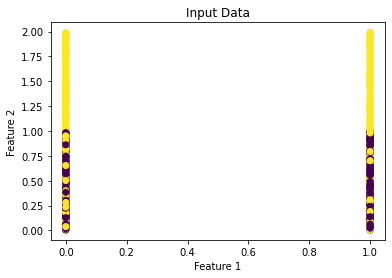

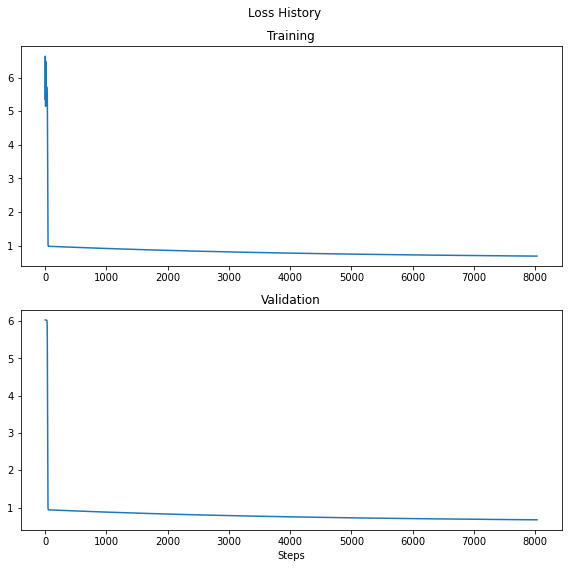

Test accuracy: 82.33%


In [79]:
np.random.seed(42)
# Load dataset
X_train, X_test, y_train, y_test = loadDataset(features=['NSCLC', 'GENDER', 'Penicillin V Potassium 250 MG', 'Penicillin V Potassium 500 MG',
    'Computed tomography of chest and abdomen', 'Plain chest X-ray (procedure)', 'Diastolic Blood Pressure',
    'Body Mass Index', 'Body Weight', 'Body Height', 'Systolic Blood Pressure',
    'Low Density Lipoprotein Cholesterol', 'High Density Lipoprotein Cholesterol', 'Triglycerides',
    'Total Cholesterol', 'Documentation of current medications',
    'Fluticasone propionate 0.25 MG/ACTUAT / salmeterol 0.05 MG/ACTUAT [Advair]',
    '24 HR Metformin hydrochloride 500 MG Extended Release Oral Tablet',
    'Carbon Dioxide', 'Hemoglobin A1c/Hemoglobin.total in Blood', 'Glucose', 'Potassium', 'Sodium', 'Calcium',
    'Urea Nitrogen', 'Creatinine', 'Chloride', 'AGE_DIAGNOSIS'], split_percent=0.7)

# Initialize logistic regression model
model = LogisticRegressor(num_feats=X_train.shape[1], learning_rate=0.001, tol=0.00001, max_iter=10000, batch_size=115)

# Plot input data
model.plot_data(X_train, y_train)

# Train model
model.train_model(X_train, y_train, X_test, y_test)

# Plot loss history
model.plot_loss_history()

# Predict labels for test set
X_test_with_bias = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
y_pred = np.round(model.make_prediction(X_test_with_bias))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Test accuracy: {:.2f}%".format(accuracy*100))


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real, Integer
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Load data
iris = load_iris()
X, y = iris.data, iris.target

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter search space
space = [
    Real(0.0001, 0.1, name='learning_rate'),
    Integer(5, 50, name='batch_size')
]

# Define objective function
def objective(params):
    lr, batch_size = params

    # Create logistic regression model
    model = LogisticRegressor(num_feats=X_train.shape[1], learning_rate=lr, batch_size=batch_size)

    # Train model on training data
    model.train_model(X_train, y_train, X_val, y_val)

    # Predict labels for validation set
    y_pred = np.round(model.make_prediction(X_val))

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)

    # Return negative accuracy (since gp_minimize minimizes the objective function)
    return -accuracy

# Run hyperparameter search
result = gp_minimize(
    objective,
    space,
    n_calls=50,
    random_state=42
)

# Print best hyperparameters and accuracy
print("Best hyperparameters: ", result.x)
print("Best accuracy: ", -result.fun)

# Plot convergence
plt.plot(result.func_vals)
plt.xlabel("Iteration")
plt.ylabel("Negative accuracy")
plt.show()


ModuleNotFoundError: No module named 'skopt'

In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load dataset
full_df = pd.read_csv("../data/nsclc.csv", index_col="ID")
features = ['NSCLC', 'GENDER', 'Penicillin V Potassium 250 MG', 'Penicillin V Potassium 500 MG',
    'Computed tomography of chest and abdomen', 'Plain chest X-ray (procedure)', 'Diastolic Blood Pressure',
    'Body Mass Index', 'Body Weight', 'Body Height', 'Systolic Blood Pressure',
    'Low Density Lipoprotein Cholesterol', 'High Density Lipoprotein Cholesterol', 'Triglycerides',
    'Total Cholesterol', 'Documentation of current medications',
    'Fluticasone propionate 0.25 MG/ACTUAT / salmeterol 0.05 MG/ACTUAT [Advair]',
    '24 HR Metformin hydrochloride 500 MG Extended Release Oral Tablet',
    'Carbon Dioxide', 'Hemoglobin A1c/Hemoglobin.total in Blood', 'Glucose', 'Potassium', 'Sodium', 'Calcium',
    'Urea Nitrogen', 'Creatinine', 'Chloride', 'AGE_DIAGNOSIS']
X = full_df.loc[:, features].values
y = full_df["NSCLC"].values

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict labels for test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Test accuracy: {:.2f}%".format(accuracy*100))


Test accuracy: 100.00%


In [62]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Load data
iris = load_iris()
X, y = iris.data, iris.target

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter search space
param_dist = {
    'learning_rate': np.logspace(-4, -1, num=100),
    'batch_size': np.arange(5, 51, step=5)
}

# Define logistic regression model
model = LogisticRegressor(num_feats=X_train.shape[1])

# Define random search object
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Fit random search object to training data
random_search.fit(X_train, y_train)

# Predict labels for validation set using best model
y_pred = np.round(random_search.best_estimator_.make_prediction(X_val))

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)

# Print best hyperparameters and accuracy
print("Best hyperparameters: ", random_search.best_params_)
print("Best accuracy: ", accuracy)


TypeError: estimator should be an estimator implementing 'fit' method, <__main__.LogisticRegressor object at 0x1561a94b0> was passed

In [81]:
def test_logistic_regression():

    # Load the dataset
    X_train, X_test, y_train, y_test = loadDataset(features=['NSCLC', 'GENDER', 'Penicillin V Potassium 250 MG', 'Penicillin V Potassium 500 MG',
        'Computed tomography of chest and abdomen', 'Plain chest X-ray (procedure)', 'Diastolic Blood Pressure',
        'Body Mass Index', 'Body Weight', 'Body Height', 'Systolic Blood Pressure',
        'Low Density Lipoprotein Cholesterol', 'High Density Lipoprotein Cholesterol', 'Triglycerides',
        'Total Cholesterol', 'Documentation of current medications',
        'Fluticasone propionate 0.25 MG/ACTUAT / salmeterol 0.05 MG/ACTUAT [Advair]',
        '24 HR Metformin hydrochloride 500 MG Extended Release Oral Tablet',
        'Carbon Dioxide', 'Hemoglobin A1c/Hemoglobin.total in Blood', 'Glucose', 'Potassium', 'Sodium', 'Calcium',
        'Urea Nitrogen', 'Creatinine', 'Chloride', 'AGE_DIAGNOSIS'], split_percent=0.7, split_seed=42)
    
    # Train the logistic regression model
    model = LogisticRegressor(num_feats=X_train.shape[1], learning_rate=0.001, tol=0.00001, max_iter=10000, batch_size=115)
    model.train_model(X_train, y_train, X_test, y_test)
    
    # Predict labels for test set
    X_test_with_bias = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    y_pred = np.round(model.make_prediction(X_test_with_bias))

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Check that accuracy is above a certain threshold
    assert accuracy > 0.7


In [82]:
#testing prediction accuracy based on an arbitrary cutoff
def test_loss_accuracy():

    # Load the dataset
    X_train, X_test, y_train, y_test = loadDataset(features=['NSCLC', 'GENDER', 'Penicillin V Potassium 250 MG', 'Penicillin V Potassium 500 MG',
        'Computed tomography of chest and abdomen', 'Plain chest X-ray (procedure)', 'Diastolic Blood Pressure',
        'Body Mass Index', 'Body Weight', 'Body Height', 'Systolic Blood Pressure',
        'Low Density Lipoprotein Cholesterol', 'High Density Lipoprotein Cholesterol', 'Triglycerides',
        'Total Cholesterol', 'Documentation of current medications',
        'Fluticasone propionate 0.25 MG/ACTUAT / salmeterol 0.05 MG/ACTUAT [Advair]',
        '24 HR Metformin hydrochloride 500 MG Extended Release Oral Tablet',
        'Carbon Dioxide', 'Hemoglobin A1c/Hemoglobin.total in Blood', 'Glucose', 'Potassium', 'Sodium', 'Calcium',
        'Urea Nitrogen', 'Creatinine', 'Chloride', 'AGE_DIAGNOSIS'], split_percent=0.7, split_seed=42)
    
    # Train the logistic regression model
    model = LogisticRegressor(num_feats=X_train.shape[1], learning_rate=0.001, tol=0.00001, max_iter=10000, batch_size=115)
    model.train_model(X_train, y_train, X_test, y_test)
    
    # Predict labels for test set
    X_test_with_bias = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    y_pred = np.round(model.make_prediction(X_test_with_bias))

    # Calculate loss for the test set using my model's loss_function method
    y_pred = model.make_prediction(X_test)
    loss = model.loss_function(y_test, y_pred)

    # Check that the loss history calculated by the model is correct
    hist_loss = model.loss_hist_train[-1]
    assert pytest.approx(loss, 0.0001) == pytest.approx(hist_loss, 0.0001)
